# Imputation *in*stability

We explore various expectile imputation strategies and their stability through repeated imputation.

In [7]:
import importlib

import numpy as np
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

from util.expectiles import expectile, tauspace
from util.gmm import EXAMPLE, GMM

import imputers
imputers = importlib.reload(imputers) # reload

# SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000, figsize=(8, 5))
R = GMM(coeffs=[0.25, 0.75], params=[[2, 1], [-2, 1]])
N = 1000
SAMPLE = R.rvs(N)
# X = np.linspace(-5, 5, 100)
# Y = R.pdf(X)
# T = np.linspace(0.01, 0.99, 11)
# E = expectile(S, T)
# plt.hist(S, density=True, alpha=0.5, bins=30)
# plt.scatter(S, np.zeros_like(S), marker="|")
# plt.plot(X, Y, color="black")
# plt.scatter(E, 0.025*np.ones_like(E), marker="x", color="blue")
# plt.show()
# print(E[5])

## Shift experiments *without* full taus

In [8]:
def shift_experiment(taus, imputer, sample=SAMPLE, n_iterations=100, n_samples=None,
                     cm=plt.cm.gist_rainbow, bins=None, **kwargs):
    if n_samples is None: n_samples = len(sample)
    print("imputation shift experiment with", imputer)
    print("n samples:    ", n_samples)
    print("n iterations: ", n_iterations)
    # record more expectiles than those provided
    full_taus = tauspace(999)
    expectiles = np.ndarray((n_iterations+1, 999))
    samples = np.ndarray((n_iterations, n_samples))
    sample0 = sample
    # perform experiment:
    expectiles[0] = expectile(sample, full_taus)
    for i in tqdm.trange(1, n_iterations+1):
        imputer.fit(expectile(sample, taus), taus, **kwargs)
        sample = imputer.sample(n_samples)
        expectiles[i] = expectile(sample, full_taus)
        samples[i-1] = sample
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.set_xlabel("asymmetry (τ)")
    ax1.set_ylabel("expectile (ε)")
    ax2.set_xlabel("sample point")
    ax2.set_ylabel("sample density")
    # visualise:
    if bins is None: bins=np.linspace(samples.min(), samples.max(), 100)
    for i in range(0, n_iterations+1, max(1, n_iterations//5)):
        ax1.plot(full_taus, expectiles[i],
                 label=f'after {i} iterations', color=cm(i/n_iterations))
        ax2.hist(samples[i-1] if i else sample0,
                 density=True, alpha=0.5, bins=bins,
                 label=f'after {i} iterations', color=cm(i/n_iterations))
    ax1.legend()
    ax2.legend()
    plt.show()
    fig, ax3 = plt.subplots(1, 1, figsize=(14, 5))
    ax3.set_xlabel("number of iterations")
    ax3.set_ylabel("expectile (ε)")
    for i in [998, 899, 799, 699, 599, 499, 399, 299, 199, 99, 0]:
        ax3.plot(expectiles[:, i], marker='x', color=cm(i/999), label=f'τ={full_taus[i]:.4f}')
    plt.legend(loc=(1.01, 0.1))
    plt.show()

In [9]:
def positive_shift_experiment(k, imputer, **kwargs):
    shift_experiment(tauspace(k)[k//2:],   imputer, i=0,    **kwargs)
def negative_shift_experiment(k, imputer, **kwargs):
    shift_experiment(tauspace(k)[:k//2+1], imputer, i=k//2, **kwargs)

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  100


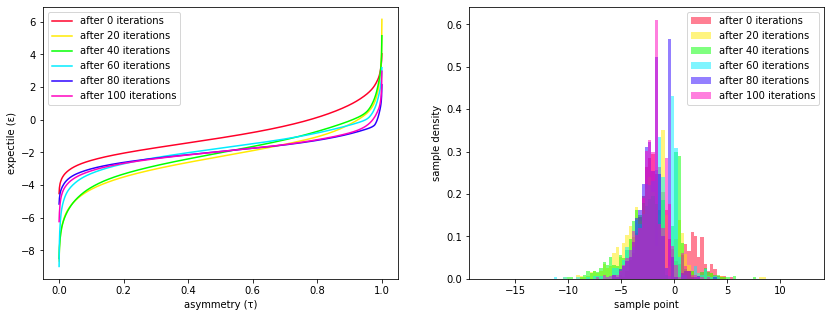

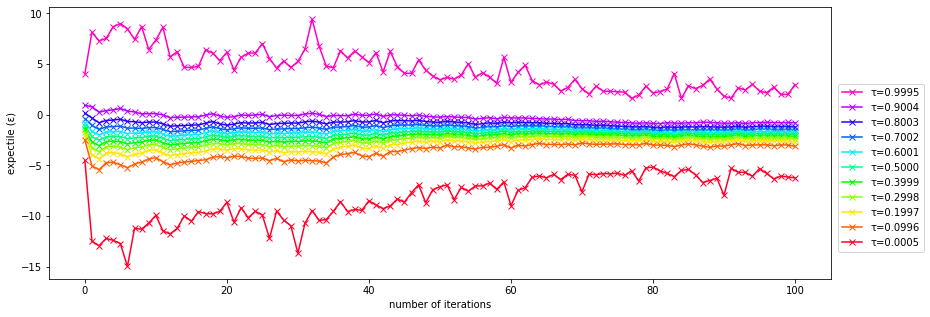

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  100


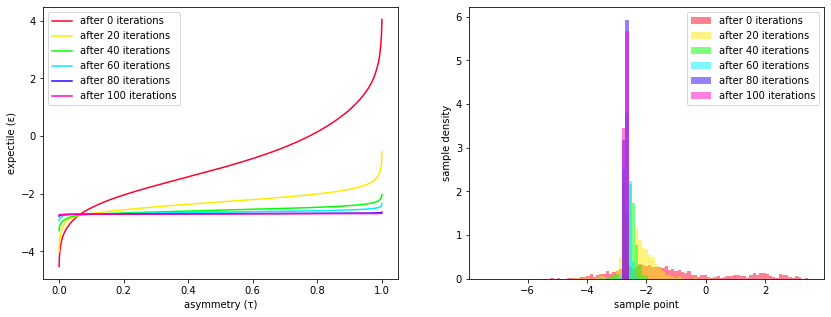

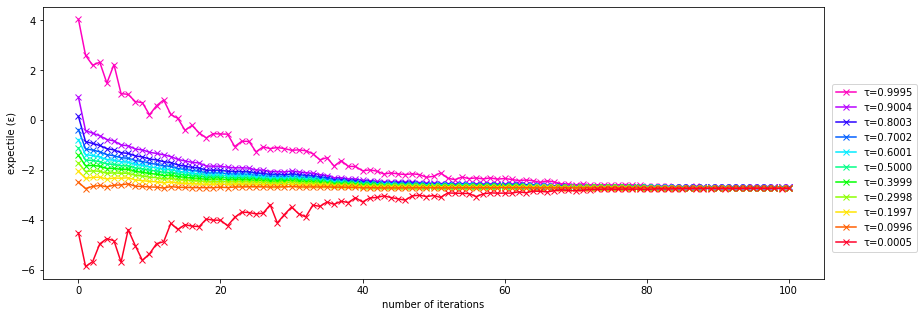

In [10]:
positive_shift_experiment(101, imputers.InterpolatingImputer())
negative_shift_experiment(101, imputers.InterpolatingImputer())

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  100


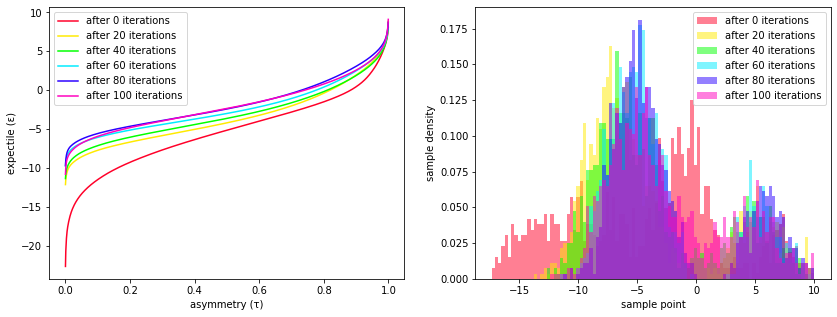

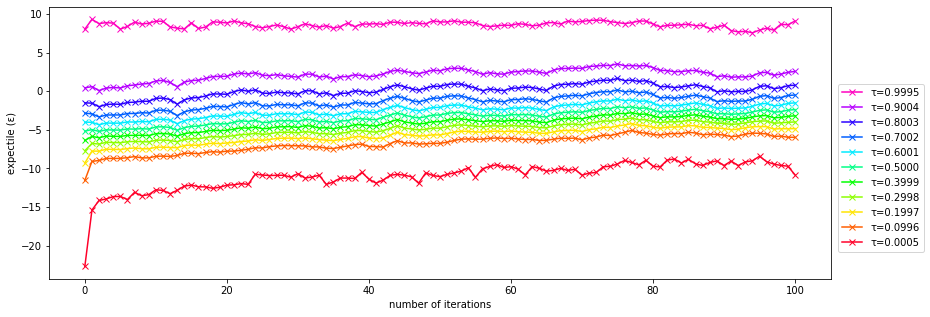

In [5]:
positive_shift_experiment(101, imputers.PolyLogitInterpImputer())

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  20


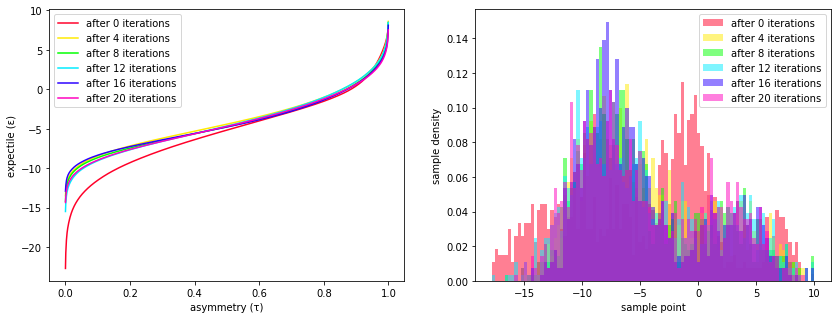

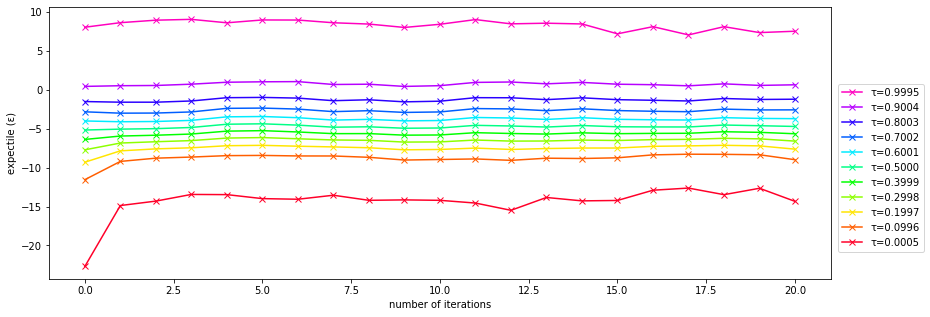

In [9]:
positive_shift_experiment(101, imputers.PolyLogitInterpImputer(), n_iterations=20)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  20


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site

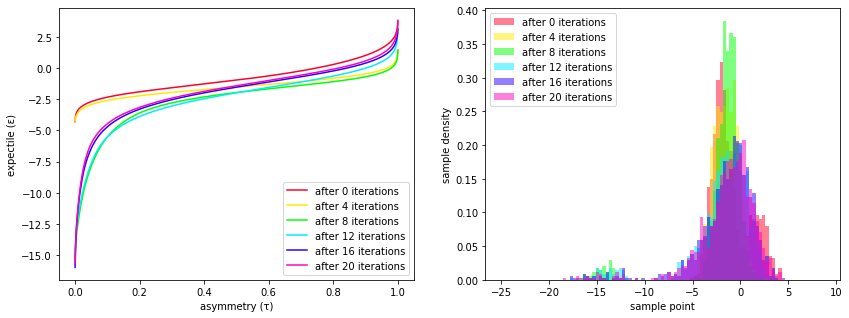

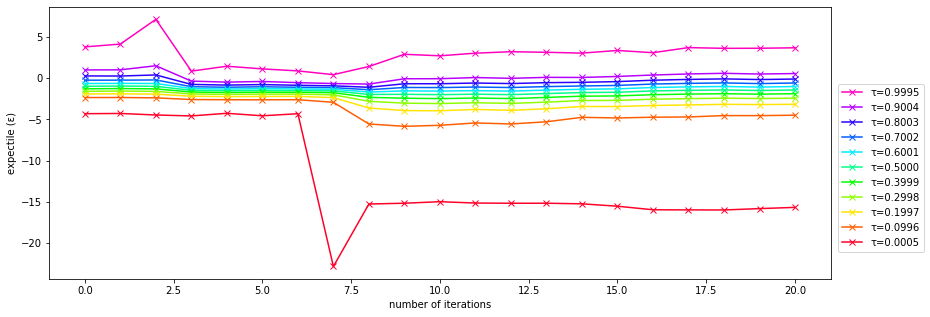

In [6]:
negative_shift_experiment(101, imputers.PolyLogitInterpImputer(), n_iterations=20)

## Opt-based imputation

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  100


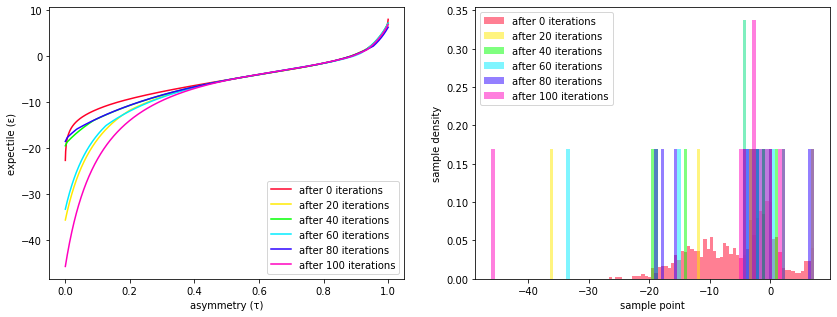

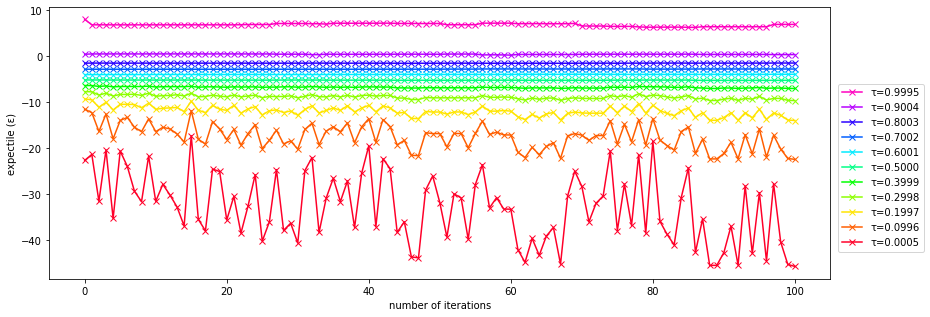

In [18]:
positive_shift_experiment(21, imputers.OptBasedImputer(), n_samples=11, n_iterations=100)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  20


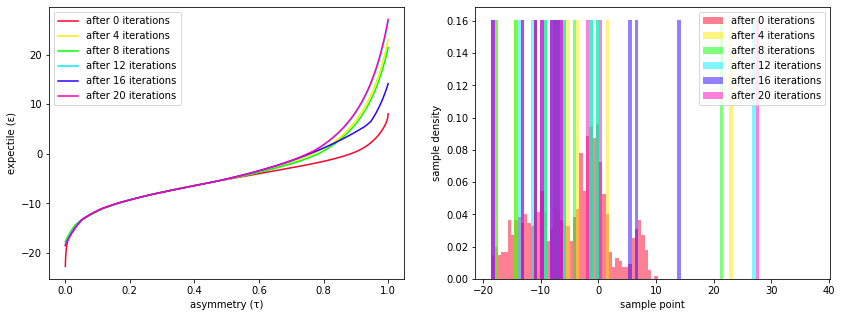

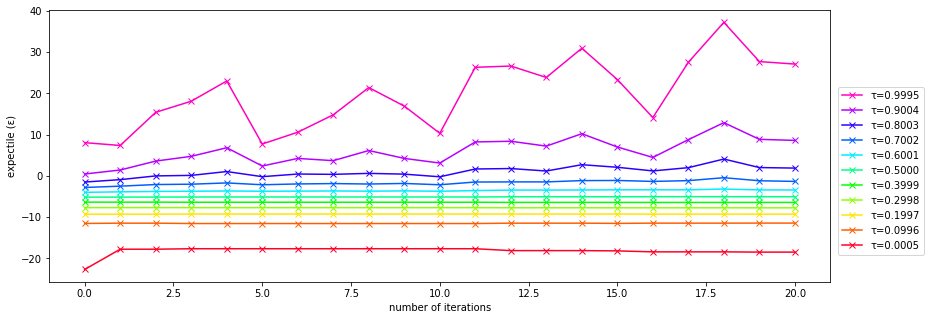

In [25]:
negative_shift_experiment(21, imputers.OptBasedImputer(), n_samples=11, n_iterations=20)